In [1]:
import sys
# !{sys.executable} -m pip install pandas scikit-learn matplotlib seaborn 
import click
import joblib
import json
import pandas as pd
import numpy as np


import time
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

from quantum.Evaluate import evaluate



/home/grierjones/miniconda3/envs/qchem/lib/python3.9/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.2' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
with open('scores.json') as f:
    d = json.load(f)
    for k,v in d.items():
        print(k,v)

ridge {'MSE_train': [0.22052354777407265], 'R2_train': 0.5608857012085625, 'MAE_train': 0.399084163415094, 'MSE_test': 0.2567698700007173, 'R2_test': 0.5211331921357041, 'MAE_test': 0.43655667172782336}
lasso {'MSE_train': [0.22066721882821022], 'R2_train': 0.5605996183170481, 'MAE_train': 0.3995335928574167, 'MSE_test': 0.25750424444039527, 'R2_test': 0.5197636095452518, 'MAE_test': 0.43724597646787167}
elastic {'MSE_train': [0.22044553117692883], 'R2_train': 0.5610410506199732, 'MAE_train': 0.3989299851560496, 'MSE_test': 0.25631590681721605, 'R2_test': 0.5219798175616956, 'MAE_test': 0.43612098391122023}
knn {'MSE_train': [0.0], 'R2_train': 1.0, 'MAE_train': 0.0, 'MSE_test': 0.03322256251501452, 'R2_test': 0.9380410853477763, 'MAE_test': 0.15580174651435413}
rfr {'MSE_train': [0.021980404768629315], 'R2_train': 0.9562318395266475, 'MAE_train': 0.12374454898256608, 'MSE_test': 0.031002556413753386, 'R2_test': 0.9421813189162522, 'MAE_test': 0.15506035160168646}
grad {'MSE_train': [0.

In [3]:
gaussian_kernel = RBF()

models = {
    'ridge': Ridge(),
    'lasso': Lasso(),
    'elastic': ElasticNet(),
    'knn': KNeighborsRegressor(),
    'rfr': RandomForestRegressor(),
    'grad': GradientBoostingRegressor(),
    'svr': SVR(),
    'krr': KernelRidge(),
    'gpr': GaussianProcessRegressor()
}

param_grid = {
    'ridge': {
        'alpha': [0.001, 0.01, 0.1, 1, 10, 50, 100, 1000]
    },
    'knn': {
        'n_neighbors': range(1, 10),
        'weights': ['uniform', 'distance']
    },
    'rfr': {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 5, 10],
        'min_samples_split': [2, 5, 10]
    },
    'grad': {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.1, 0.01, 0.001],
        'max_depth': [3, 5, 7]
    },
    'svr': {
        'kernel': ['linear', 'rbf'],
        'C': [0.1, 1, 10],
        'epsilon': [0.1, 0.01, 0.001]
    },
    'krr': {
        'kernel': ['linear', 'poly', 'rbf'],
        'alpha': [0.001, 0.01, 0.1, 1],
        'gamma': [1, 0.1, 0.01, 0.001]
    },
    'gpr': {
        'alpha': [0.0001, 0.001, 0.01, 0.1, 1],
        'kernel': [gaussian_kernel]
    },
    'lasso': {
        'alpha': [0.001, 0.01, 0.1, 1],
        'max_iter': [1000, 2000, 3000]
    },
    'elastic': {
        'alpha': [0.001, 0.01, 0.1, 1],
        'l1_ratio': [0.2, 0.5, 0.8],
        'max_iter': [1000, 2000, 3000]
    }
}

'''
def score_model(model, sacler, X_tr, y_tr, X_te, y_te):
    """
    :param X_tr:
    :param model:
    :param X_te:
    :param y_tr:  y training data
    :param y_te:  y test data
    :return:  scores: dict ['r2_tr', 'r2_te', 'mse_tr', 'mse_te', 'rmse_tr', rmse_te']
    """
    y_tr_pred = model.predict(X_tr)
    y_te_pred = model.predict(X_te)
    train_r2 = r2_score(y_tr, y_tr_pred)
    train_mse = mean_squared_error(y_tr, y_tr_pred)
    train_mae = mean_absolute_error(y_tr, y_tr_pred)
    test_r2 = r2_score(y_te, y_te_pred)
    test_mse = mean_squared_error(y_te, y_te_pred)
    test_mae = mean_absolute_error(y_te, y_te_pred)
    scores = {
        'r2_tr': train_r2,
        'r2_te': test_r2,
        'mse_tr': train_mse,
        'mse_te': test_mse,
        'mae_tr': train_mae,
        'mae_te': test_mae
    }
    print(scores['mae_tr'], scores['mae_te'])
    scores = list(scores.values())
    return scores
'''


def classical_regressor(model: str, scaler, X_tr, y_tr, X_te, y_te, plot=True, save=False):
    """
    :param scaler:
    :param model: defines the model to run, raises a ValueError if unexpected type
    :param X_tr: X training data
    :param y_tr: y training data
    :param X_te: X testing data
    :param y_te: y testing data
    :param plot: whether to produce a plot, plot will be predicted vs actual
    :param save: whether to save the plot saves to /plots/model.png
    :return: returns current_scores dict of test scores from evaluate function
    """
    if model not in models.keys():
        raise ValueError('Model must be one of', models.keys())

    st = time.time()
    current_model = models[model]
    current_param_grid = param_grid[model]

    grid_search = GridSearchCV(current_model, current_param_grid, cv=5)

    print(f'Now fitting {model}... ')

    grid_search.fit(X_tr, y_tr)

    best_model = grid_search.best_estimator_

    print(f'Completed fitting {model} in {time.time() - st} seconds. ')

    current_scores, y_te_pred, y_tr_pred = evaluate(model=best_model, X_train=X_tr, X_test=X_te, y_train=y_tr,
                                                    y_test=y_te, y_scaler=scaler, plot=True, title=model)
    if plot:
        plt.scatter(y_te, y_te_pred, color='r', label='Test data')
        plt.scatter(y_tr, y_tr_pred, color='b', label='Train data')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.legend()
        if save:
            plt.savefig('plots/' + model + '.png')
        plt.show()
    return current_scores, y_te_pred, y_tr_pred


def run_models(scaler, X_tr, y_tr, X_te, y_te, save_plots):
    scores = dict()
    keys = ["Train", "Test"]
    y_te_pred = {}
    y_tr_pred = {}
    for model in models.keys():
        scores[model], y_te_pred[model], y_tr_pred[model] = classical_regressor(model, scaler, X_tr, y_tr, X_te, y_te,
                                                                                plot=save_plots)

    """
    for i in range(3):  # 3 because we have 3 different scoring types, this will loop over each of them and create a
        # bar plot comparing the models for each scoring metric
        heights = list(scores.values())
        heights = np.array(heights).transpose()
        heights = dict(zip(keys, heights[i*2:2*i+2]))  # because keys only has two elements this zips the first two
        # lists in ith set of lists which corresponds to a score type.

        width = 0.25
        multiplier = 0
        bar_clusters = np.arange(len(scores.keys()))

        fig, ax = plt.subplots(layout='constrained')

        for key, height in heights.items():
            offset = width * multiplier
            bar_plt = plt.bar(bar_clusters + offset, height, width, label=key)
            plt.bar_label(bar_plt)
            multiplier += 1
        ax.set_xticks(bar_clusters + width, scores.keys())
        ax.legend(loc='upper left', ncols=2)
        titles = ['R2 Scores', 'MSE', 'MAE']
        ax.set_title(titles[i])
        plt.show()
        if save_plots:
            plt.savefig('plots/model_comparison.svg')

    """

    return scores, y_tr_pred, y_te_pred


In [4]:
# with open('classical_testing/BSE/BSE49_full_train.bin','rb') as f:
#     print(f.readlines()[0:100])

In [5]:
# --scaler ./classical_testing/BSE/BSE49_full_scaler.bin --train_set ./classical_testing/BSE/BSE49_full_train.bin --test_set ./classical_testing/BSE/BSE49_full_test.bin

Now fitting ridge... 
Completed fitting ridge in 0.41175341606140137 seconds. 
Now scoring model... 
Scoring complete taking 0.14867091178894043 seconds. 


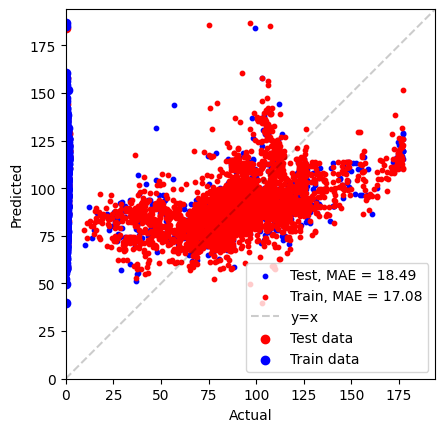

Now fitting lasso... 
Completed fitting lasso in 0.6821064949035645 seconds. 
Now scoring model... 
Scoring complete taking 0.1388108730316162 seconds. 


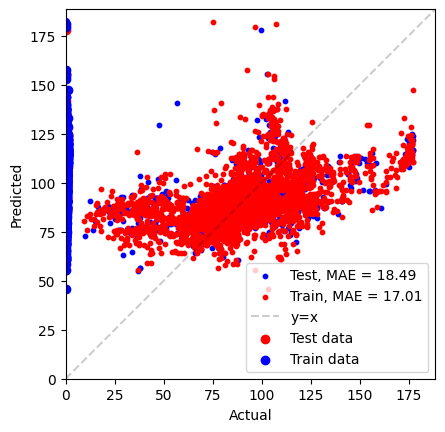

Now fitting elastic... 
Completed fitting elastic in 3.547808885574341 seconds. 
Now scoring model... 
Scoring complete taking 0.14322376251220703 seconds. 


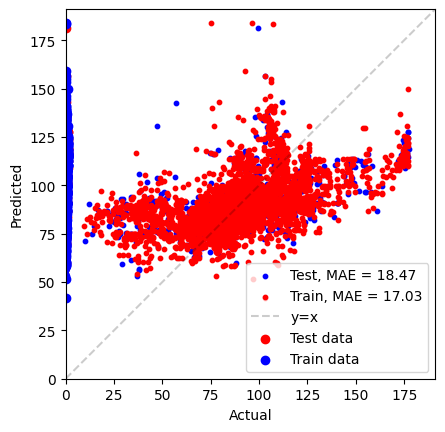

Now fitting knn... 
Completed fitting knn in 0.4170875549316406 seconds. 
Now scoring model... 
Scoring complete taking 0.11788415908813477 seconds. 


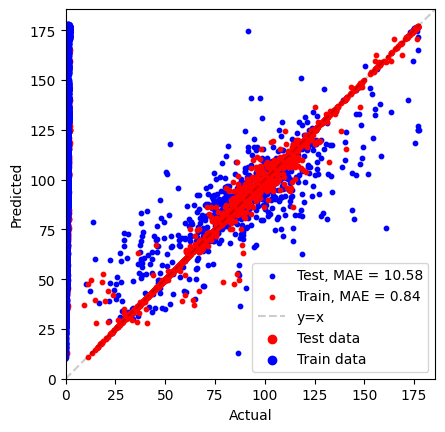

Now fitting rfr... 
Completed fitting rfr in 417.335280418396 seconds. 
Now scoring model... 
Scoring complete taking 0.19655323028564453 seconds. 


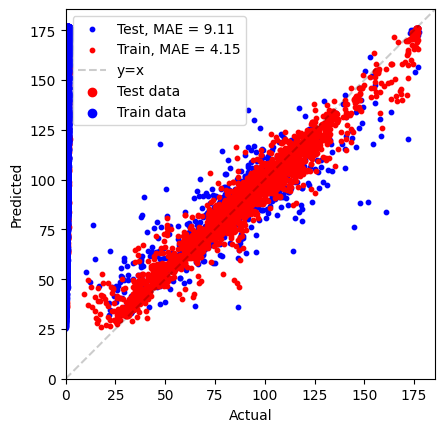

Now fitting grad... 
Completed fitting grad in 374.6864426136017 seconds. 
Now scoring model... 
Scoring complete taking 0.10283732414245605 seconds. 


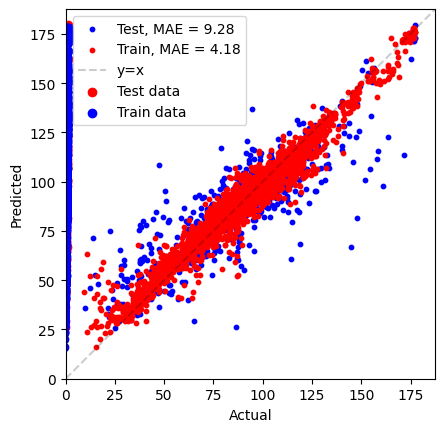

Now fitting svr... 
Completed fitting svr in 45.138575315475464 seconds. 
Now scoring model... 
Scoring complete taking 0.48457884788513184 seconds. 


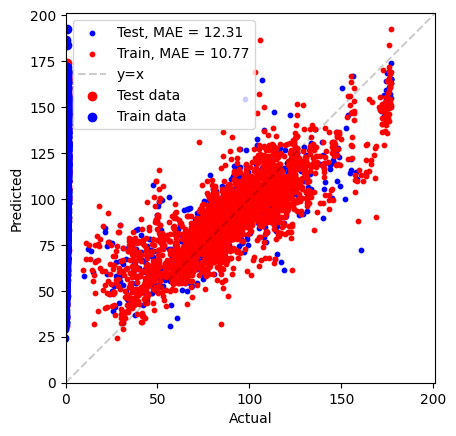

Now fitting krr... 
Completed fitting krr in 35.5556263923645 seconds. 
Now scoring model... 
Scoring complete taking 0.20127177238464355 seconds. 


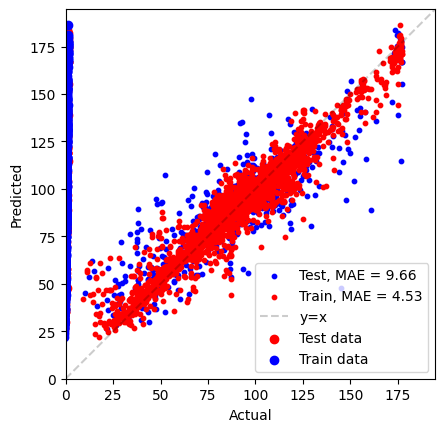

Now fitting gpr... 


/home/grierjones/miniconda3/envs/qchem/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/grierjones/miniconda3/envs/qchem/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/grierjones/miniconda3/envs/qchem/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/grierjones/miniconda3/

Completed fitting gpr in 103.59822130203247 seconds. 
Now scoring model... 
Scoring complete taking 0.8700318336486816 seconds. 


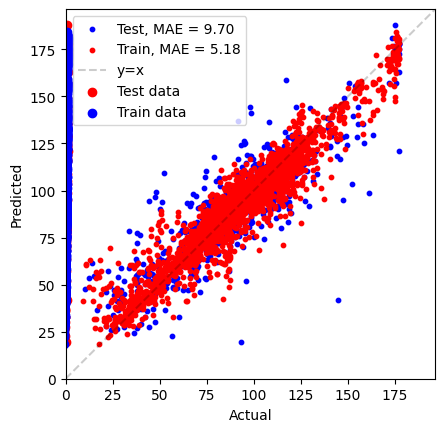

Saved predicted values as ridge_predicted_values.csv
Saved predicted values as lasso_predicted_values.csv
Saved predicted values as elastic_predicted_values.csv
Saved predicted values as knn_predicted_values.csv
Saved predicted values as rfr_predicted_values.csv
Saved predicted values as grad_predicted_values.csv
Saved predicted values as svr_predicted_values.csv
Saved predicted values as krr_predicted_values.csv
Saved predicted values as gpr_predicted_values.csv
Scores saved as scores.json. 


In [6]:

scaler= "./classical_testing/BSE/BSE49_full_scaler.bin" 
train_set= "./classical_testing/BSE/BSE49_full_train.bin" 
test_set="./classical_testing/BSE/BSE49_full_test.bin"

def main(scaler, train_set, test_set, save_plots):
    train = joblib.load(train_set)
    test = joblib.load(test_set)
    X_tr = train['X']
    X_te = test['X']
    y_tr = np.array(train['y']).reshape(-1)
    y_te = np.array(test['y']).reshape(-1)
    scaler = joblib.load(scaler)

    scores, y_tr_pred, y_te_pred = run_models(scaler, X_tr, y_tr, X_te, y_te, save_plots)

    y_tr = scaler.inverse_transform(y_tr.reshape(-1, 1))
    y_te = scaler.inverse_transform(y_te.reshape(-1, 1))

    for (model_name, train_pred), (test_pred) in zip(y_tr_pred.items(), y_te_pred.values()):
        name = model_name + '_predicted_values.csv'
        train_pred = np.array(train_pred).reshape(-1).tolist()
        y_tr = np.array(y_tr).reshape(-1).tolist()
        test_pred = np.array(test_pred).reshape(-1).tolist()
        y_te = np.array(y_te).reshape(-1).tolist()

        df_train = pd.DataFrame({'Predicted': train_pred, 'Reference': y_tr})
        df_train['Data'] = 'Train'
        df_test = pd.DataFrame({'Predicted': test_pred, 'Reference': y_te})
        df_test['Data'] = 'Test'
        df = pd.concat([df_train, df_test], ignore_index=True)
        df = df[['Data', 'Predicted', 'Reference']]

        df.to_csv(name, index=False)
        print(f'Saved predicted values as {name}')

    with open('scores.json', 'w') as outfile:
        json.dump(scores, outfile)
        print(f'Scores saved as {outfile.name}. ')


if __name__ == '__main__':
    main(scaler, train_set, test_set, True)
